In [ ]:
import zipfile
with zipfile.ZipFile("image_color_train.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

with zipfile.ZipFile("image_color_test.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [ ]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.layers import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard,  ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
BATCH_SIZE = 32
TRAIN_FOLDER = "/content/image_color_train"
TEST_FOLDER = "/content/image_color_test"

In [ ]:
inception = InceptionResNetV2(weights="imagenet", include_top=True)

In [ ]:
class CustomGenerator():
    def __init__(self, generator, directory, batch_size):
        self.batch_index = 0
        self.batch_size = batch_size
        self.generator_X = generator.flow_from_directory(directory,
                                                        target_size=(256, 256),
                                                        class_mode=None,
                                                        color_mode='rgb',
                                                        batch_size=batch_size,
                                                        shuffle=True)
        self.n = self.generator_X.samples


    def reset_index(self):
        self.generator_X._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        return self.n // self.batch_size

    def __next__(self):
        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0
        X1 = self.generator_X.next()

        l = []
        ab = []
        inc_emb = []

        for im in X1:
          lab_im = rgb2lab(im)
          grey_im = gray2rgb(rgb2gray(im))
          l.append(lab_im[:,:,0])
          inc_emb.append(resize(grey_im,(299,299)))
          ab.append(lab_im[:,:,1:]/128)
        
        l = np.array(l)
        ab = np.array(ab)
        inc_emb = np.array(inc_emb)
        inc_emb = inception.predict(inc_emb)

        return ([l, inc_emb], ab)

    def __iter__(self):
        while True:
            yield next(self)


datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)


def return_custom_generators():
    train_generator = CustomGenerator(datagen, TRAIN_FOLDER, BATCH_SIZE)
    test_generator = CustomGenerator(datagen, TEST_FOLDER, BATCH_SIZE)

    return train_generator, test_generator

In [ ]:
# -*- coding: utf-8 -*-
"""colorization.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1fc-uJ43PJ3MvB_bDIrNmQVf8bmAHuAzC
"""


"""Crear modelo con doble entrada, una imagen de 256x256 para el encoder-decoder
 y un vector de 1000 del Inception"""

embed_input = Input(shape=(1000,))

#Encoder 
encoder_input = Input(shape=(256, 256, 1,)) # l
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# salida del encoder => 256@32x32

#Fusion 
fusion_output = RepeatVector(32 * 32)(embed_input) # duplicamos la salida de la inception tantas veces como el tamaño de la imagen
fusion_output = Reshape(([32, 32, 1000]))(fusion_output) # le damos el shape necesario
fusion_output = concatenate([encoder_output, fusion_output], axis=3) # concatenamos a la codificación => 1256@32x32
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) # para compactar la información => 256@32x32

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output) # 128@32x32
decoder_output = UpSampling2D((2, 2))(decoder_output) # 128@64x64
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output) # 64@64x64
decoder_output = UpSampling2D((2, 2))(decoder_output) # 64@128x128
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output) # 32@128x128
decoder_output = UpSampling2D((2, 2))(decoder_output) # 32@256x256 
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output) # 16@256x256
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output) # 2@256x256 que sería el ab predecido

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

train_gen, test_gen = return_custom_generators()

"""Compilar y entrenar"""
model_path = './IC_model.hdf5'
best_model_path = './best_IC_model.hdf5'
save_best_model = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', patience=8, min_lr=1e-7)
model.fit(train_gen, steps_per_epoch=500/BATCH_SIZE, validation_data=test_gen, validation_steps=50/BATCH_SIZE, epochs=300, callbacks=[save_best_model, lr_on_plateau])
model.save_weights(model_path)

Found 500 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Epoch 1/300
16/15 [==============================] - ETA: -1s - loss: 0.0716
Epoch 1: val_loss improved from inf to 0.01266, saving model to ./best_IC_model.hdf5
15/15 [==============================] - 66s 4s/step - loss: 0.0716 - val_loss: 0.0127 - lr: 0.0010
Epoch 2/300
16/15 [==============================] - ETA: 0s - loss: 0.0140
Epoch 2: val_loss improved from 0.01266 to 0.01121, saving model to ./best_IC_model.hdf5
15/15 [==============================] - 43s 3s/step - loss: 0.0140 - val_loss: 0.0112 - lr: 0.0010
Epoch 3/300
16/15 [==============================] - ETA: 0s - loss: 0.0134
Epoch 3: val_loss did not improve from 0.01121
15/15 [==============================] - 43s 3s/step - loss: 0.0134 - val_loss: 0.0120 - lr: 0.0010
Epoch 4/300
16/15 [==============================] - ETA: 0s - loss: 0.0129
Epoch 4: val_loss did not improve from 0.01121
15/15 [==============================] - 39s 3

Original


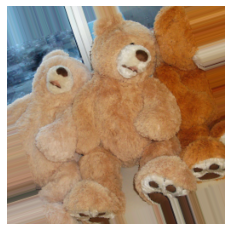

Luminancia original


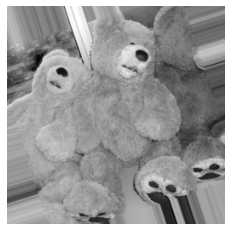

Imagen colorizada


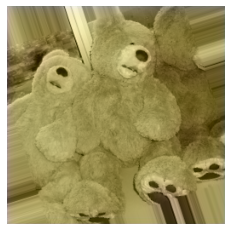

In [ ]:
"""Probar el modelo con imagenes de test"""
[l, inc_emb], ab = next(test_gen)
ab = ab
lab_final = l # 64 imagenes de 256x256
lab_final = np.expand_dims(lab_final, axis=3) # 64 1@256x256
original_lab = np.concatenate((lab_final, ab * 128), axis=3) # 64 3@256x256
original_rgb = lab2rgb(original_lab)

ab_hat = model.predict([l, inc_emb]) # 64 2@256x256
ab_hat *= 128
lab_images = np.concatenate((lab_final, ab_hat), axis=3) # 64 3@256x256
rgb_images = lab2rgb(lab_images)

print("Original")
plt.imshow(original_rgb[0])
plt.axis("off")
plt.show()
print("Luminancia original")
plt.imshow(l[0], cmap="gray")
plt.axis("off")
plt.show()
print("Imagen colorizada")
plt.imshow(rgb_images[0])
plt.axis("off")
plt.show()